In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.stattools import adfuller

In [15]:
df = pd.read_excel('merged17-20.xlsx')
df.head()

,Неделя,Всього захворіло,у т.ч.діти до 17 років,18 - 29,30 - 64,65 та старші,Госпіталізація,Показник захворюваності,Епідпоріг,Перевищення епідпорогу (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.0,7891.0,5836.0,639.0,1147.0,269.0,142.0,291.94,527.44,-44.65
2,42.0,6736.0,4928.0,517.0,1029.0,262.0,160.0,249.21,541.73,-54.00
3,43.0,6835.0,4392.0,796.0,1307.0,340.0,147.0,252.87,634.05,-60.12
4,44.0,7595.0,4965.0,870.0,1377.0,383.0,160.0,280.99,568.92,-50.61


In [16]:
df = df.iloc[1:]
dic = list(df.columns)
col_dict = dict(zip(dic, ['week', 'total','upto17', '18-29', '30-64', '65+', 'hospital', 'indicator', 'epid', 'epid excess']))
df2 = df.rename(columns = col_dict, inplace = False)
df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']] \
= df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']].astype(int)
# df2.set_index('week', inplace=True, drop=True)
df2.head()

,week,total,upto17,18-29,30-64,65+,hospital,indicator,epid,epid excess
1,41,7891,5836,639,1147,269,142,291.94,527.44,-44.65
2,42,6736,4928,517,1029,262,160,249.21,541.73,-54.00
3,43,6835,4392,796,1307,340,147,252.87,634.05,-60.12
4,44,7595,4965,870,1377,383,160,280.99,568.92,-50.61
5,45,8209,5511,894,1448,356,168,303.70,572.42,-46.94


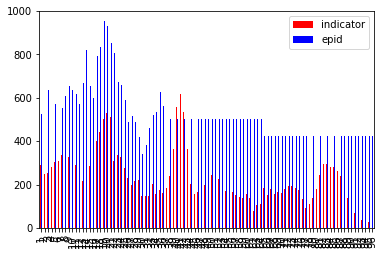

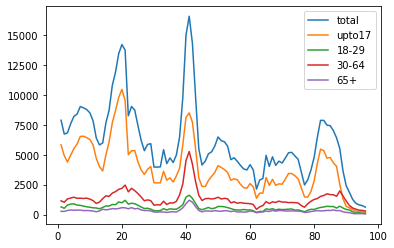

In [17]:
# df2.iloc[:, 1].plot(kind='bar', color='grey')
df2.iloc[:, 7:9].plot(kind='bar', color=['red', 'blue'])
df3 = df2.iloc[:, 1:6]
df3.plot()
# df2 = df2.iloc[42:, :]
# df2.iloc[:, 7].plot(kind='bar', color='black')


<Figure size 432x288 with 0 Axes>

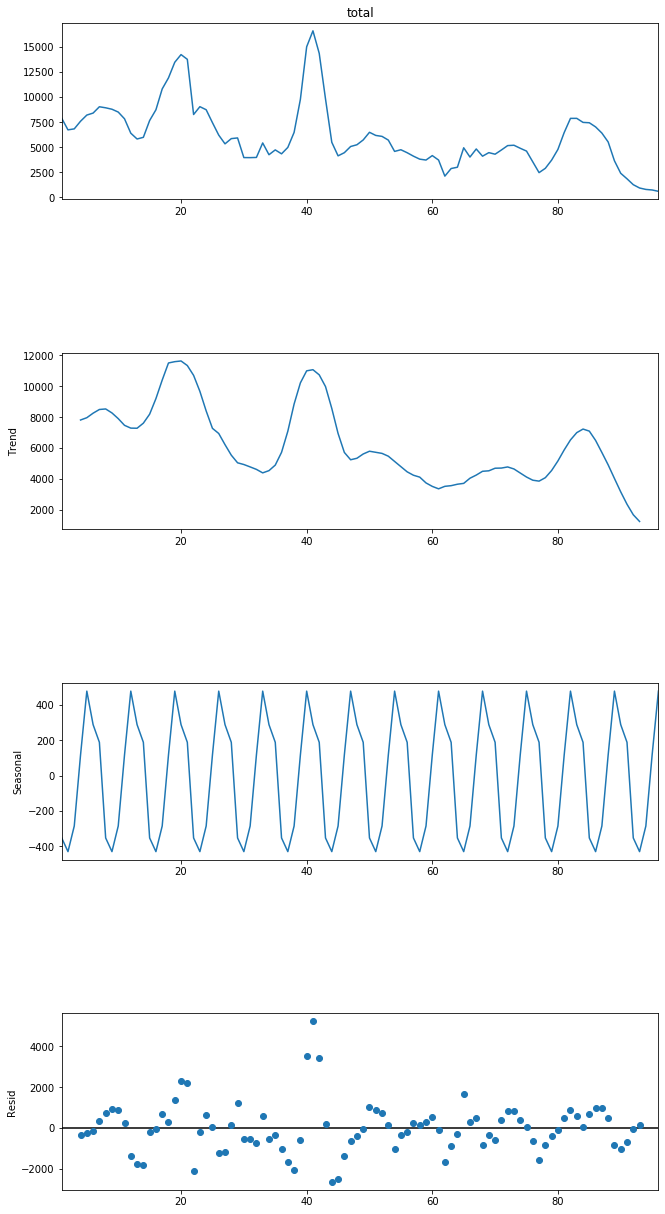

In [18]:
decomposition = seasonal_decompose(df2.total, period=7)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 20)

In [19]:
trend = decomposition.trend
seasonal = decomposition.seasonal
print(trend, seasonal, sep='\n')
# df2.resample('3T').sum()

1             NaN
2             NaN
3             NaN
4     7815.857143
5     7964.714286
         ...     
92    1671.571429
93    1237.142857
94            NaN
95            NaN
96            NaN
Name: trend, Length: 96, dtype: float64
1    -353.160518
2    -430.479199
3    -285.663265
4     116.224097
5     477.388932
         ...    
92   -353.160518
93   -430.479199
94   -285.663265
95    116.224097
96    477.388932
Name: seasonal, Length: 96, dtype: float64


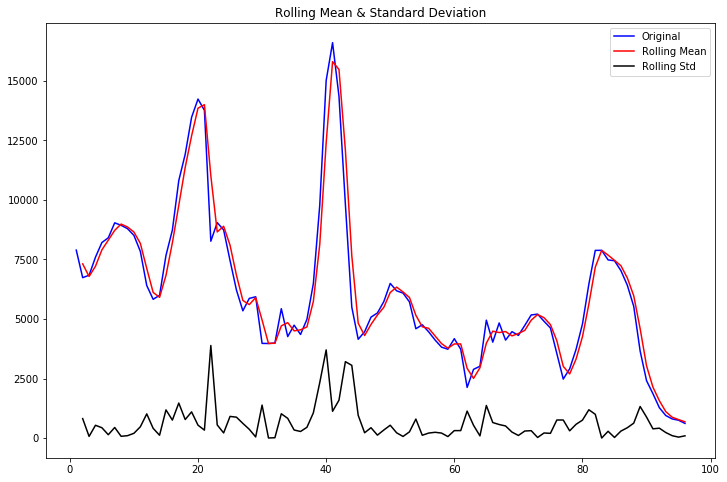

Results of Dickey-Fuller Test:
Test Statistic                 -3.560385
p-value                         0.006565
#Lags Used                      1.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=2).mean()
    rolstd = pd.Series(timeseries).rolling(window=2).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.total)

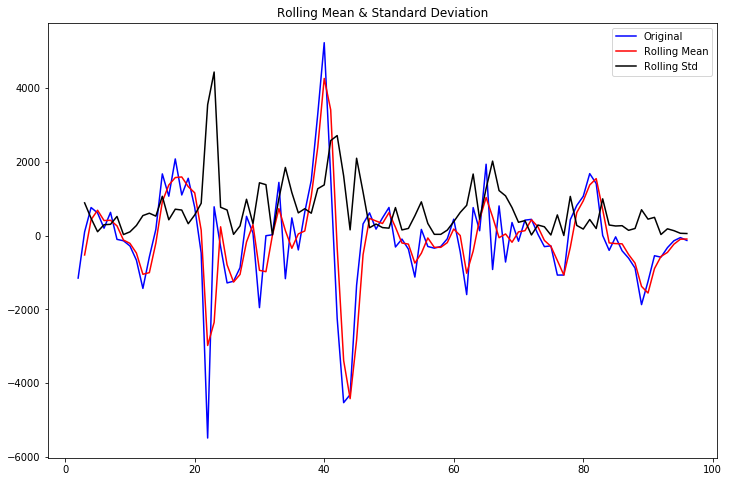

Results of Dickey-Fuller Test:
Test Statistic                -6.405543e+00
p-value                        1.947434e-08
#Lags Used                     2.000000e+00
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


In [21]:
#first difference
df2['first_diff'] = df2.total - df2.total.shift(1)
test_stationarity(df2.first_diff.dropna(inplace=False))

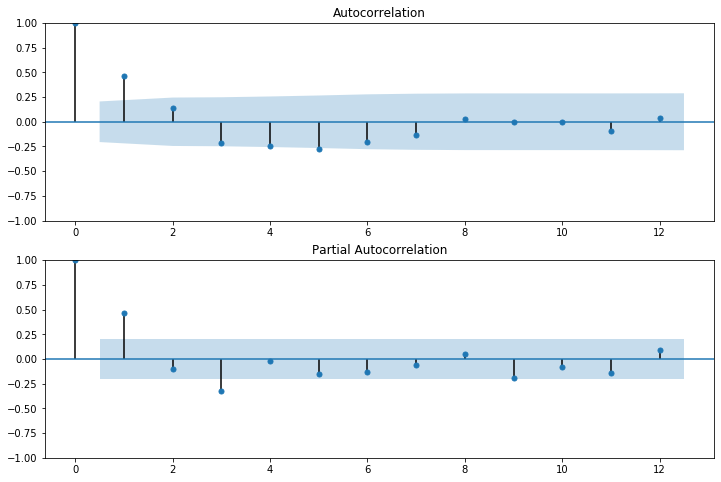

In [22]:
#ACF and PACF charts
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df2.first_diff[5:], lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df2.first_diff.iloc[5:], lags=12, ax=ax2)

In [23]:
mod = SARIMAX(df2.total, trend='n', order=(1,0,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                total   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -742.165
Date:                              Wed, 03 Nov 2021   AIC                           1492.330
Time:                                      22:59:40   BIC                           1502.053
Sample:                                           0   HQIC                          1496.238
                                               - 96                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8800      0.036     24.152      0.000       0.809       0.951
ar.S.L12      -0.00

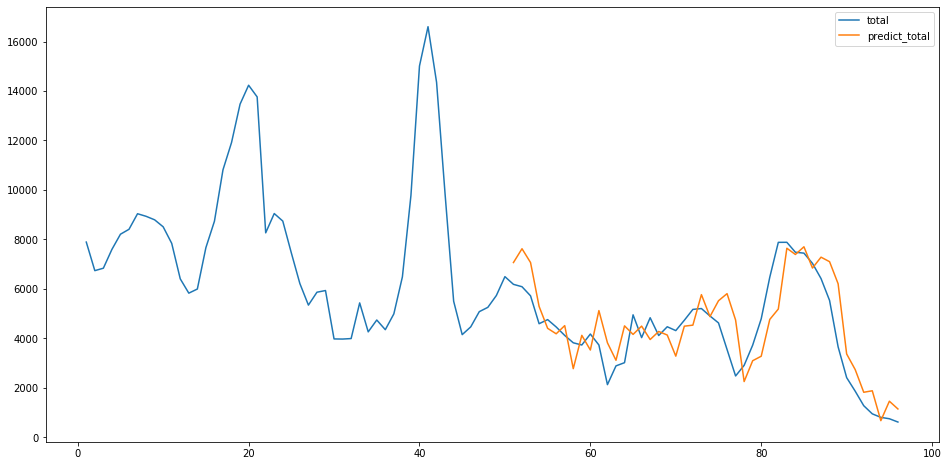

In [24]:
df2['predict_total'] = results.predict(start=50, end=96, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))

In [25]:
# npredict = df2.total[0].shape[0]
# fig, ax = plt.subplots(figsize=(12,6))
# npre = 12
# ax.set(title='Total flu', xlabel='Week', ylabel='Infected')
# ax.plot(df2.index[-npredict-npre+1:], df2.ix[-npredict-npre+1:, 'total'], 'o', label='Observed')
# ax.plot(df2.index[-npredict-npre+1:], df2.ix[-npredict-npre+1:, 'preditc_totall'], 'g', label='Dynamic predict_total')
# legend = ax.legend(loc='lower right')
# legend.get_frame().set_facecolor('w')

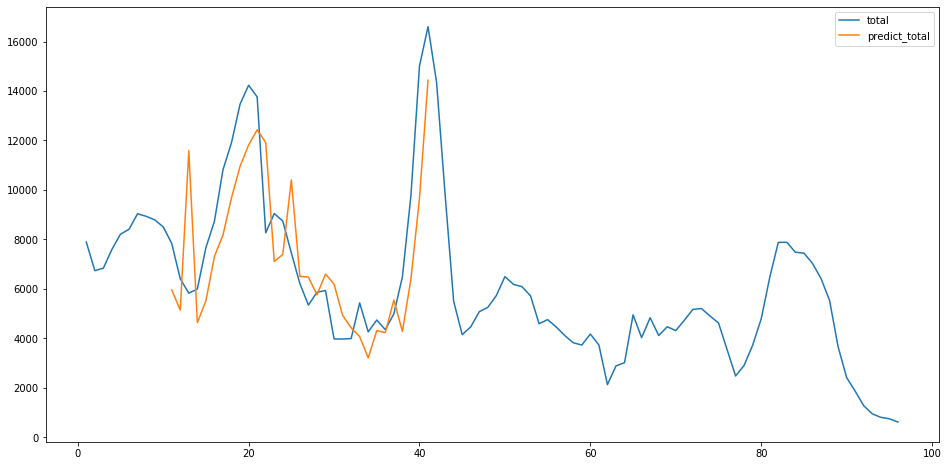

In [26]:
df2['predict_total'] = results.predict(start=10, end=40, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))